In [2]:
from models import get_model
import torch

import torch.nn as nn

C:\Users\Achyut Burlakoti\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
model = get_model('conv-mix')

model.to(torch.device('cuda'))

ConvMixer(
  (conv1): Conv2d(3, 768, kernel_size=(4, 4), stride=(4, 4))
  (gelu1): GELU(approximate='none')
  (batchnorm1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convmixblock): Sequential(
    (0): ConvMixerBlock(
      (resblock): Residual(
        (conv1): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=768)
        (gelu): GELU(approximate='none')
        (batchnorm): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1))
      (gelu1): GELU(approximate='none')
      (batchnorm1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvMixerBlock(
      (resblock): Residual(
        (conv1): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=768)
        (gelu): GELU(approximate='none')
        (batchnorm): BatchNorm2d(768, eps=1e-05, momentum=0.1, 

In [4]:
path = './models/conv-mix.pt'

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
from dataset import ImageDataset

In [6]:
BATCH_SIZE = 16

In [7]:
test_dataset = ImageDataset(status="test")

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
parameter = []

for child in model.children():
    for param in child.parameters():
        parameter.append(param)

### Simple hook to extract the output from last conv layer from the model

In [9]:
last_conv_output = None

def hook(module, input, out):
    global last_conv_output
    last_conv_output = out

In [10]:
model.convmixblock[-1].conv1.register_forward_hook(hook)

In [11]:
import numpy as np
import scipy.ndimage

import matplotlib.pyplot as plt

In [12]:
model.eval()

ConvMixer(
  (conv1): Conv2d(3, 768, kernel_size=(4, 4), stride=(4, 4))
  (gelu1): GELU(approximate='none')
  (batchnorm1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convmixblock): Sequential(
    (0): ConvMixerBlock(
      (resblock): Residual(
        (conv1): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=768)
        (gelu): GELU(approximate='none')
        (batchnorm): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1))
      (gelu1): GELU(approximate='none')
      (batchnorm1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvMixerBlock(
      (resblock): Residual(
        (conv1): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=768)
        (gelu): GELU(approximate='none')
        (batchnorm): BatchNorm2d(768, eps=1e-05, momentum=0.1, 

In [13]:
# get image from test dataset

input = test_dataset.__getitem__(1000)[0]
data = input.permute(1, 2 ,0)
input = input.unsqueeze(0)

pred_vec = model(input.to(torch.device('cuda')))

last_conv_output = last_conv_output.squeeze(0)
last_conv_output = last_conv_output.permute(1, 2, 0)

pred = np.argmax(pred_vec.cpu().detach().numpy())

In [14]:
print("Predicted Label : ", pred, " Actual Label : ", test_dataset.__getitem__(1000)[1])

Predicted Label :  1  Actual Label :  1


In [15]:
last_conv_output.shape

torch.Size([16, 16, 768])

In [16]:
# upscaling the last convolutional layer output

h = int(64 / last_conv_output.shape[0])
w = int(64 / last_conv_output.shape[1])

upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output.cpu().detach().numpy(), (h, w, 1), order=1)

last_layer_weights = parameter[-2]
last_layer_weights = last_layer_weights.permute(1, 0)

last_layer_weights_for_pred = last_layer_weights[:, pred]

In [17]:
heat_map = np.dot(upsampled_last_conv_output.reshape((64*64, 768)), last_layer_weights_for_pred.cpu().detach().numpy()).reshape(64, 64)

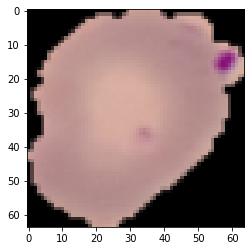

In [18]:
fig, ax = plt.subplots()
ax.imshow(data)
fig.savefig('original-output.png')

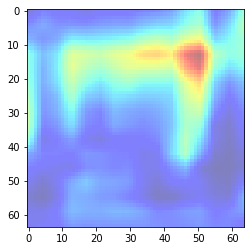

In [19]:
fig, ax = plt.subplots()
ax.imshow(heat_map, cmap='jet', alpha=0.2)
fig.savefig('cam-conv-mix.png')

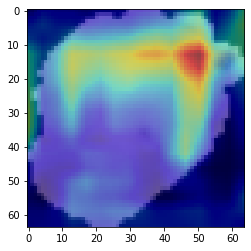

In [19]:
fig, ax = plt.subplots()
ax.imshow(data)
ax.imshow(heat_map, cmap='jet', alpha=0.5)
fig.savefig('')